<center><h2>Covid 2019</h2></center>
<a href="http://theconversation.com/how-to-model-a-pandemic-134187" style="color:black;font-size:15px;" ><strong>SIR model explained</strong>></a>

In [3]:
import numpy as np
# import pandas as pd
import modin.pandas as pd   ############## To make pandas faster, requires dask, distributed packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, YearLocator, MonthLocator
from datetime import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# %matplotlib notebook
%matplotlib inline

In [2]:
# Functions for Bayesian Regression
def getPolynomialDataMatrix(x, degree):
    Xtilde = np.ones(x.shape)
    for i in range(1,degree + 1):
        Xtilde = np.column_stack((Xtilde, x ** i))
    return Xtilde

def getBetaForPolynomialFit(x, y, degree):
    Xtilde = getPolynomialDataMatrix(x, degree)
    XX = Xtilde.transpose().dot(Xtilde)
    regularizer = np.eye(XX.shape[0]) * 10 **-6
    betaTilde = np.linalg.solve(XX + regularizer, Xtilde.transpose().dot(y))
    return betaTilde

def getBayesianBetaForPolynomialFit(x, y, degree, sigma, regLambda):  # Gaussian Bayes rule 2
    # get polynomi
    Xtilde = getPolynomialDataMatrix(x, degree)
    XX = Xtilde.transpose().dot(Xtilde)
    regularizer = np.eye(XX.shape[0]) * regLambda * sigma
    betaTilde = np.linalg.solve(XX + regularizer, Xtilde.transpose().dot(y))
    sigmaBeta = sigma * np.linalg.inv(XX + regularizer)
    return betaTilde, sigmaBeta

In [3]:
df = pd.read_csv('./Historic COVID-19 Dashboard Data.csv')
# data = pd.read_csv('/home/ash/Downloads/Historic COVID-19 Dashboard Data.csv',
#                     usecols=['Date', 'Cases', 'Cumulative Cases'], )

df.head()
# data.head()

,Date,Cases,Cumulative Cases,Deaths,Cumulative Deaths UK,Cumulative Deaths England,Cumulative Deaths Northern Ireland,Cumulative Deaths Scotland,Cumulative Deaths Wales,Cumulative Recovered Patients
0,31/01/2020,2.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN
1,01/02/2020,0.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN
2,02/02/2020,0.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN
3,03/02/2020,0.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN
4,04/02/2020,0.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)

uni_data = df['Cumulative Cases'].dropna()
uni_data.index = df.index.dropna()
uni_data.head()

Date
2020-01-31    2.0
2020-02-01    2.0
2020-02-02    2.0
2020-02-03    2.0
2020-02-04    2.0
Name: Cumulative Cases, dtype: float64

In [5]:
def plotData(df, symbol, axisLocator='Year'):
    fig, ax = plt.subplots()
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    fig.subplots_adjust(bottom=0.2)
    
    if axisLocator == 'month':
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_major_formatter(weekFormatter)
        
    ax.plot(df[symbol])
    ax.scatter(df.index, df[symbol])
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax
#     plt.show()
    
    # ax.xaxis.set_minor_formatter(dayFormatter)
    # ax.xaxis.set_minor_locator(alldays)
    # ax.xaxis.set_major_locator(YearLocator())
    # ax.xaxis.set_major_locator(MonthLocator((1,2,3)))

    # ax.xaxis.set_major_formatter(DateFormatter("\n%m"))
    # ax.xaxis.set_minor_formatter(DateFormatter("%b"))

    # df[symbol].plot(ax=ax)
    
    # ax.plot(df['Cumulative Cases'])
    # ax.set_xticks(df.index)
    # ax.set_xticks(df['Date'])

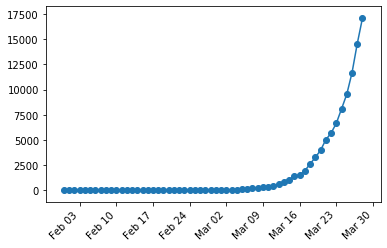

In [6]:
plotData(df, 'Cumulative Cases', axisLocator='month')  # axisLocator is either Year or month which comes on X axis

In [7]:
# date_index.map(dt.fromordinal)
# [2020-01-31].map(dt.toordinal)
# df['Cumulative Cases']
uni_data.index.dropna()
df.index

DatetimeIndex(['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11',
               '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15',
               '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
               '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
      

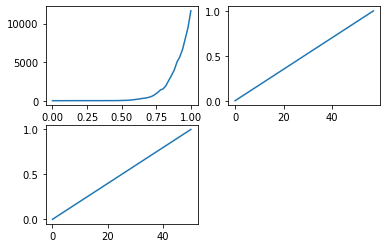

In [38]:
start_date, end_date = '2020-02-05', '2020-03-26'
dates = pd.date_range(start_date, end_date)  # date range as index
date_index = dates.map(dt.toordinal)

scaler = MinMaxScaler()
full_dates = uni_data.index.map(dt.toordinal)
full_dates = full_dates.to_numpy().reshape(-1, 1)
full_dates = scaler.fit_transform(full_dates)

X_tran = date_index.to_numpy().reshape(-1, 1)
y_train = df.loc[start_date:end_date, ['Cumulative Cases']]

# from sklearn import preprocessing
X_tran = scaler.fit_transform(X_tran)
# y_train = scaler.fit_transform(y_train)


plt.subplot(221)
plt.plot(X_tran, y_train)
plt.subplot(222)
plt.plot(full_dates)
plt.subplot(223)
plt.plot(X_tran)


# X_tet = X_test.to_numpy().reshape(-1, 1)
# x_train = df.loc[start_date:end_date, ['Cumulative Cases']]

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(date_index, df['Cumulative Cases'],
#                                                     test_size=0.8, random_state=3)
# X_tran = X_train.to_numpy().reshape(-1, 1)
# X_tet = X_test.to_numpy().reshape(-1, 1)
# X_train.map(dt.fromordinal)
# X_tran

## Bayesian Regression

In [40]:
degree, sigma, regLambda = 4, 25, 10**-8

beta, sigmaBeta = getBayesianBetaForPolynomialFit(X_tran,y_train, degree, sigma, regLambda)

# compute predictive mean
x_test = full_dates
X_test = getPolynomialDataMatrix(x_test, degree)
y_pred = X_test.dot(beta)

# Compute predictive variance for each data point
y_sigma = np.zeros((X_test.shape[0]))
for i in range(X_test.shape[0]):
    y_sigma[i] = sigma + X_test[i,:].dot(sigmaBeta.dot(X_test[i,:].T))


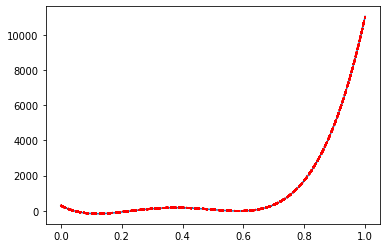

In [41]:
plt.plot(x_test, y_pred)
# ax.plot(x_test,y_pred, 'r')
plt.plot(x_test, y_pred + 2 * np.sqrt(y_sigma), 'r--')
plt.plot(x_test, y_pred - 2 * np.sqrt(y_sigma), 'r--')

## Neural Networks

In [51]:
import tensorflow as tf  # library for machine learning
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(input_shape=[1], units=100, activation='relu'),
                            tf.keras.layers.Dense(units=100, activation='relu'),
                            tf.keras.layers.Dense(units=100, activation='relu'),
                            tf.keras.layers.Dense(units=100, activation='relu'),
                            tf.keras.layers.Dense(units=1)
                            ])
# model.compile(optimizer='sgd', loss='mean_squared_error')
model.compile(optimizer='Adam', loss='mean_squared_error')
# model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(X_tran, np.ravel(y_train), epochs=500, steps_per_epoch=40,
                      verbose=1)  # Find out the parameters


Epoch 1/5000
40/40 [==============================] - 0s 9ms/step - loss: 8571251.4250
Epoch 2/5000
40/40 [==============================] - 0s 2ms/step - loss: 8073183.7125
Epoch 3/5000
40/40 [==============================] - 0s 2ms/step - loss: 5952132.9500
Epoch 4/5000
40/40 [==============================] - 0s 2ms/step - loss: 5237478.3125
Epoch 5/5000
40/40 [==============================] - 0s 2ms/step - loss: 4715358.3500
Epoch 6/5000
40/40 [==============================] - 0s 2ms/step - loss: 4065621.7000
Epoch 7/5000
40/40 [==============================] - 0s 2ms/step - loss: 3188098.4938
Epoch 8/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952446.7375
Epoch 9/5000
40/40 [==============================] - 0s 2ms/step - loss: 805917.3234
Epoch 10/5000
40/40 [==============================] - 0s 2ms/step - loss: 268802.7824
Epoch 11/5000
40/40 [==============================] - 0s 2ms/step - loss: 106550.6719
Epoch 12/5000
40/40 [=======================

40/40 [==============================] - 0s 2ms/step - loss: 2026.7375
Epoch 98/5000
40/40 [==============================] - 0s 2ms/step - loss: 2006.4577
Epoch 99/5000
40/40 [==============================] - 0s 2ms/step - loss: 2026.0308
Epoch 100/5000
40/40 [==============================] - 0s 2ms/step - loss: 2025.1662
Epoch 101/5000
40/40 [==============================] - 0s 2ms/step - loss: 2008.3010
Epoch 102/5000
40/40 [==============================] - 0s 2ms/step - loss: 2011.4598
Epoch 103/5000
40/40 [==============================] - 0s 2ms/step - loss: 2014.5339
Epoch 104/5000
40/40 [==============================] - 0s 2ms/step - loss: 2010.0815
Epoch 105/5000
40/40 [==============================] - 0s 2ms/step - loss: 2013.4068
Epoch 106/5000
40/40 [==============================] - 0s 2ms/step - loss: 2003.0377
Epoch 107/5000
40/40 [==============================] - 0s 2ms/step - loss: 2007.0247
Epoch 108/5000
40/40 [==============================] - 0s 2ms/step - l

40/40 [==============================] - 0s 2ms/step - loss: 1953.6650
Epoch 288/5000
40/40 [==============================] - 0s 2ms/step - loss: 2046.7342
Epoch 289/5000
40/40 [==============================] - 0s 2ms/step - loss: 1954.4552
Epoch 290/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.5976
Epoch 291/5000
40/40 [==============================] - 0s 2ms/step - loss: 1992.8259
Epoch 292/5000
40/40 [==============================] - 0s 2ms/step - loss: 2023.9868
Epoch 293/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.0138
Epoch 294/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.1399
Epoch 295/5000
40/40 [==============================] - 0s 2ms/step - loss: 1954.1662
Epoch 296/5000
40/40 [==============================] - 0s 2ms/step - loss: 2059.7964
Epoch 297/5000
40/40 [==============================] - 0s 2ms/step - loss: 1954.4984
Epoch 298/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 1956.2831
Epoch 478/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6987
Epoch 479/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6243
Epoch 480/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6192
Epoch 481/5000
40/40 [==============================] - 0s 2ms/step - loss: 2083.8696
Epoch 482/5000
40/40 [==============================] - 0s 2ms/step - loss: 1974.3501
Epoch 483/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.9547
Epoch 484/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6148
Epoch 485/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6077
Epoch 486/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6333
Epoch 487/5000
40/40 [==============================] - 0s 2ms/step - loss: 2116.5459
Epoch 488/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 1951.5112
Epoch 668/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5083
Epoch 669/5000
40/40 [==============================] - 0s 2ms/step - loss: 2178.4298
Epoch 670/5000
40/40 [==============================] - 0s 2ms/step - loss: 1971.1464
Epoch 671/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.7983
Epoch 672/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5210
Epoch 673/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.5123
Epoch 674/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5059
Epoch 675/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5087
Epoch 676/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5094
Epoch 677/5000
40/40 [==============================] - 0s 2ms/step - loss: 2084.4160
Epoch 678/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 2153.3087
Epoch 858/5000
40/40 [==============================] - 0s 2ms/step - loss: 1958.8314
Epoch 859/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5872
Epoch 860/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4515
Epoch 861/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4402
Epoch 862/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4411
Epoch 863/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4391
Epoch 864/5000
40/40 [==============================] - 0s 2ms/step - loss: 2109.6067
Epoch 865/5000
40/40 [==============================] - 0s 1ms/step - loss: 1989.7889
Epoch 866/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.1355
Epoch 867/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4520
Epoch 868/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 1959.3811
Epoch 953/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5727
Epoch 954/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4175
Epoch 955/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4138
Epoch 956/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4495
Epoch 957/5000
40/40 [==============================] - 0s 2ms/step - loss: 2120.5326
Epoch 958/5000
40/40 [==============================] - 0s 2ms/step - loss: 1960.2826
Epoch 959/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.5618
Epoch 960/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4198
Epoch 961/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4127
Epoch 962/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4131
Epoch 963/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 1951.4272
Epoch 1141/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3912
Epoch 1142/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3917
Epoch 1143/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.3803
Epoch 1144/5000
40/40 [==============================] - 0s 2ms/step - loss: 2105.4851
Epoch 1145/5000
40/40 [==============================] - 0s 1ms/step - loss: 1954.0689
Epoch 1146/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.4476
Epoch 1147/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3862
Epoch 1148/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3880
Epoch 1149/5000
40/40 [==============================] - 0s 2ms/step - loss: 2006.0421
Epoch 1150/5000
40/40 [==============================] - 0s 2ms/step - loss: 2046.6143
Epoch 1151/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 2119.5781
Epoch 1329/5000
40/40 [==============================] - 0s 2ms/step - loss: 1989.3836
Epoch 1330/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.9727
Epoch 1331/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3706
Epoch 1332/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3557
Epoch 1333/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3514
Epoch 1334/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3558
Epoch 1335/5000
40/40 [==============================] - 0s 2ms/step - loss: 1987.4108
Epoch 1336/5000
40/40 [==============================] - 0s 2ms/step - loss: 2077.3923
Epoch 1337/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.8212
Epoch 1338/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3845
Epoch 1339/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.3163
Epoch 1517/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3156
Epoch 1518/5000
40/40 [==============================] - 0s 1ms/step - loss: 2082.5268
Epoch 1519/5000
40/40 [==============================] - 0s 2ms/step - loss: 1977.2474
Epoch 1520/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.7568
Epoch 1521/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3255
Epoch 1522/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.3149
Epoch 1523/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3153
Epoch 1524/5000
40/40 [==============================] - 0s 2ms/step - loss: 2085.9007
Epoch 1525/5000
40/40 [==============================] - 0s 2ms/step - loss: 2020.6016
Epoch 1526/5000
40/40 [==============================] - 0s 1ms/step - loss: 1952.3453
Epoch 1527/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.2987
Epoch 1705/5000
40/40 [==============================] - 0s 2ms/step - loss: 1955.2262
Epoch 1706/5000
40/40 [==============================] - 0s 2ms/step - loss: 2115.1093
Epoch 1707/5000
40/40 [==============================] - 0s 2ms/step - loss: 1954.2346
Epoch 1708/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3441
Epoch 1709/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.2959
Epoch 1710/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2949
Epoch 1711/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.6898
Epoch 1712/5000
40/40 [==============================] - 0s 2ms/step - loss: 2078.7932
Epoch 1713/5000
40/40 [==============================] - 0s 2ms/step - loss: 1955.1207
Epoch 1714/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3770
Epoch 1715/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.2885
Epoch 1799/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2850
Epoch 1800/5000
40/40 [==============================] - 0s 2ms/step - loss: 2109.6300
Epoch 1801/5000
40/40 [==============================] - 0s 2ms/step - loss: 1977.0169
Epoch 1802/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.7051
Epoch 1803/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2948
Epoch 1804/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2922
Epoch 1805/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2903
Epoch 1806/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.8139
Epoch 1807/5000
40/40 [==============================] - 0s 2ms/step - loss: 2086.8815
Epoch 1808/5000
40/40 [==============================] - 0s 2ms/step - loss: 1954.5432
Epoch 1809/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 2123.5564
Epoch 1987/5000
40/40 [==============================] - 0s 2ms/step - loss: 1959.6859
Epoch 1988/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3754
Epoch 1989/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2532
Epoch 1990/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2503
Epoch 1991/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2544
Epoch 1992/5000
40/40 [==============================] - 0s 2ms/step - loss: 1974.7980
Epoch 1993/5000
40/40 [==============================] - 0s 2ms/step - loss: 2086.9319
Epoch 1994/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.7931
Epoch 1995/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2821
Epoch 1996/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2507
Epoch 1997/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.2134
Epoch 2175/5000
40/40 [==============================] - 0s 2ms/step - loss: 1960.8729
Epoch 2176/5000
40/40 [==============================] - 0s 1ms/step - loss: 2074.3714
Epoch 2177/5000
40/40 [==============================] - 0s 2ms/step - loss: 1952.7843
Epoch 2178/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2459
Epoch 2179/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2158
Epoch 2180/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.2233
Epoch 2181/5000
40/40 [==============================] - 0s 2ms/step - loss: 2114.2445
Epoch 2182/5000
40/40 [==============================] - 0s 2ms/step - loss: 1960.8770
Epoch 2183/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3893
Epoch 2184/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2180
Epoch 2185/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 2061.4523
Epoch 2363/5000
40/40 [==============================] - 0s 2ms/step - loss: 1958.9826
Epoch 2364/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3000
Epoch 2365/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.1866
Epoch 2366/5000
40/40 [==============================] - 0s 2ms/step - loss: 1956.9026
Epoch 2367/5000
40/40 [==============================] - 0s 2ms/step - loss: 2071.7987
Epoch 2368/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.1306
Epoch 2369/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2201
Epoch 2370/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.1861
Epoch 2371/5000
40/40 [==============================] - 0s 2ms/step - loss: 1956.9139
Epoch 2372/5000
40/40 [==============================] - 0s 2ms/step - loss: 2077.9321
Epoch 2373/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.1125
Epoch 2551/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.1120
Epoch 2552/5000
40/40 [==============================] - 0s 2ms/step - loss: 2073.3808
Epoch 2553/5000
40/40 [==============================] - 0s 2ms/step - loss: 1973.5125
Epoch 2554/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.4258
Epoch 2555/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.1170
Epoch 2556/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.1086
Epoch 2557/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.3841
Epoch 2558/5000
40/40 [==============================] - 0s 2ms/step - loss: 2076.3855
Epoch 2559/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.7538
Epoch 2560/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.1495
Epoch 2561/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 4ms/step - loss: 1960.1313
Epoch 2739/5000
40/40 [==============================] - 0s 3ms/step - loss: 1951.2288
Epoch 2740/5000
40/40 [==============================] - 0s 3ms/step - loss: 1951.0653
Epoch 2741/5000
40/40 [==============================] - 0s 3ms/step - loss: 1951.0678
Epoch 2742/5000
40/40 [==============================] - 0s 3ms/step - loss: 2071.6666
Epoch 2743/5000
40/40 [==============================] - 0s 3ms/step - loss: 1965.8225
Epoch 2744/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2906
Epoch 2745/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.0676
Epoch 2746/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.0608
Epoch 2747/5000
40/40 [==============================] - 0s 2ms/step - loss: 1953.8540
Epoch 2748/5000
40/40 [==============================] - 0s 2ms/step - loss: 2129.2150
Epoch 2749/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 1951.0242
Epoch 2927/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.0218
Epoch 2928/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.5252
Epoch 2929/5000
40/40 [==============================] - 0s 3ms/step - loss: 2087.6569
Epoch 2930/5000
40/40 [==============================] - 0s 4ms/step - loss: 1954.4133
Epoch 2931/5000
40/40 [==============================] - 0s 3ms/step - loss: 1951.0839
Epoch 2932/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.0170
Epoch 2933/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.0198
Epoch 2934/5000
40/40 [==============================] - 0s 3ms/step - loss: 2062.7553
Epoch 2935/5000
40/40 [==============================] - 0s 2ms/step - loss: 1970.4081
Epoch 2936/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.3885
Epoch 2937/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 2ms/step - loss: 2051.0146
Epoch 3115/5000
40/40 [==============================] - 0s 2ms/step - loss: 2003.4029
Epoch 3116/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.8978
Epoch 3117/5000
40/40 [==============================] - 0s 2ms/step - loss: 1950.9791
Epoch 3118/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.9635
Epoch 3119/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.9623
Epoch 3120/5000
40/40 [==============================] - 0s 1ms/step - loss: 2053.3533
Epoch 3121/5000
40/40 [==============================] - 0s 1ms/step - loss: 2009.6609
Epoch 3122/5000
40/40 [==============================] - 0s 1ms/step - loss: 1951.9089
Epoch 3123/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.9852
Epoch 3124/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.9637
Epoch 3125/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 1ms/step - loss: 1950.9896
Epoch 3303/5000
40/40 [==============================] - 0s 2ms/step - loss: 1950.9357
Epoch 3304/5000
40/40 [==============================] - 0s 2ms/step - loss: 1950.9353
Epoch 3305/5000
40/40 [==============================] - 0s 2ms/step - loss: 2073.1023
Epoch 3306/5000
40/40 [==============================] - 0s 2ms/step - loss: 1969.6049
Epoch 3307/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2117
Epoch 3308/5000
40/40 [==============================] - 0s 2ms/step - loss: 1950.9365
Epoch 3309/5000
40/40 [==============================] - 0s 2ms/step - loss: 1950.9306
Epoch 3310/5000
40/40 [==============================] - 0s 2ms/step - loss: 1951.2972
Epoch 3311/5000
40/40 [==============================] - 0s 2ms/step - loss: 2100.2462
Epoch 3312/5000
40/40 [==============================] - 0s 2ms/step - loss: 1955.3871
Epoch 3313/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 1ms/step - loss: 1951.0677
Epoch 3491/5000
40/40 [==============================] - 0s 1ms/step - loss: 2090.3838
Epoch 3492/5000
40/40 [==============================] - 0s 1ms/step - loss: 1954.9870
Epoch 3493/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.9476
Epoch 3494/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8673
Epoch 3495/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8661
Epoch 3496/5000
40/40 [==============================] - 0s 1ms/step - loss: 1973.2791
Epoch 3497/5000
40/40 [==============================] - 0s 1ms/step - loss: 2084.2563
Epoch 3498/5000
40/40 [==============================] - 0s 1ms/step - loss: 1952.3860
Epoch 3499/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8983
Epoch 3500/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8681
Epoch 3501/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 1ms/step - loss: 1951.3698
Epoch 3679/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8324
Epoch 3680/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8247
Epoch 3681/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8215
Epoch 3682/5000
40/40 [==============================] - 0s 1ms/step - loss: 1964.3764
Epoch 3683/5000
40/40 [==============================] - 0s 1ms/step - loss: 2079.6619
Epoch 3684/5000
40/40 [==============================] - 0s 1ms/step - loss: 1952.7151
Epoch 3685/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8574
Epoch 3686/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8223
Epoch 3687/5000
40/40 [==============================] - 0s 1ms/step - loss: 1950.8202
Epoch 3688/5000
40/40 [==============================] - 0s 1ms/step - loss: 2062.5007
Epoch 3689/5000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 1ms/step - loss: 457.1920
Epoch 3868/5000
40/40 [==============================] - 0s 1ms/step - loss: 453.3720
Epoch 3869/5000
40/40 [==============================] - 0s 1ms/step - loss: 453.0545
Epoch 3870/5000
40/40 [==============================] - 0s 1ms/step - loss: 452.9800
Epoch 3871/5000
40/40 [==============================] - 0s 1ms/step - loss: 452.9656
Epoch 3872/5000
40/40 [==============================] - 0s 1ms/step - loss: 586.5531
Epoch 3873/5000
40/40 [==============================] - 0s 1ms/step - loss: 543.0031
Epoch 3874/5000
40/40 [==============================] - 0s 1ms/step - loss: 459.3006
Epoch 3875/5000
40/40 [==============================] - 0s 1ms/step - loss: 453.1996
Epoch 3876/5000
40/40 [==============================] - 0s 1ms/step - loss: 453.0174
Epoch 3877/5000
40/40 [==============================] - 0s 1ms/step - loss: 452.9631
Epoch 3878/5000
40/40 [==============================] - 0s 1ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 453.2044
Epoch 4058/5000
40/40 [==============================] - 0s 2ms/step - loss: 516.0032
Epoch 4059/5000
40/40 [==============================] - 0s 2ms/step - loss: 462.3200
Epoch 4060/5000
40/40 [==============================] - 0s 2ms/step - loss: 453.0212
Epoch 4061/5000
40/40 [==============================] - 0s 2ms/step - loss: 547.3276
Epoch 4062/5000
40/40 [==============================] - 0s 2ms/step - loss: 644.7738
Epoch 4063/5000
40/40 [==============================] - 0s 2ms/step - loss: 458.4282
Epoch 4064/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.9657
Epoch 4065/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.8307
Epoch 4066/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.8187
Epoch 4067/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.8141
Epoch 4068/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 452.7947
Epoch 4248/5000
40/40 [==============================] - 0s 2ms/step - loss: 748.3237
Epoch 4249/5000
40/40 [==============================] - 0s 2ms/step - loss: 503.5520
Epoch 4250/5000
40/40 [==============================] - 0s 2ms/step - loss: 453.7592
Epoch 4251/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7920
Epoch 4252/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7618
Epoch 4253/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7545
Epoch 4254/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7507
Epoch 4255/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7496
Epoch 4256/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7484
Epoch 4257/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7475
Epoch 4258/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 452.6625
Epoch 4438/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6601
Epoch 4439/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6579
Epoch 4440/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6559
Epoch 4441/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6550
Epoch 4442/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6539
Epoch 4443/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6528
Epoch 4444/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6525
Epoch 4445/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.6511
Epoch 4446/5000
40/40 [==============================] - 0s 2ms/step - loss: 455.3296
Epoch 4447/5000
40/40 [==============================] - 0s 2ms/step - loss: 593.1316
Epoch 4448/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 588.9947
Epoch 4628/5000
40/40 [==============================] - 0s 2ms/step - loss: 466.1264
Epoch 4629/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.7888
Epoch 4630/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5676
Epoch 4631/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5629
Epoch 4632/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5629
Epoch 4633/5000
40/40 [==============================] - 0s 2ms/step - loss: 558.5329
Epoch 4634/5000
40/40 [==============================] - 0s 2ms/step - loss: 516.1304
Epoch 4635/5000
40/40 [==============================] - 0s 2ms/step - loss: 453.7589
Epoch 4636/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5821
Epoch 4637/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5613
Epoch 4638/5000
40/40 [==============================] - 0s 2ms/step -

40/40 [==============================] - 0s 2ms/step - loss: 452.4713
Epoch 4818/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4707
Epoch 4819/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4691
Epoch 4820/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4684
Epoch 4821/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4677
Epoch 4822/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4668
Epoch 4823/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4667
Epoch 4824/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4665
Epoch 4825/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.4648
Epoch 4826/5000
40/40 [==============================] - 0s 2ms/step - loss: 452.5218
Epoch 4827/5000
40/40 [==============================] - 0s 2ms/step - loss: 685.5184
Epoch 4828/5000
40/40 [==============================] - 0s 2ms/step -

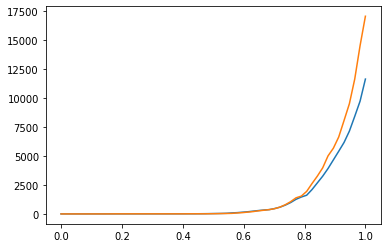

In [52]:
xTest = full_dates
# xTest
prediction = model.predict(xTest)  # 
# print(prediction)
# ax = plotData(df, 'Cumulative Cases', axisLocator='month') 
plt.plot(xTest, prediction)
plt.plot(xTest, df['Cumulative Cases'].dropna())